When should we start SIREN and how often should we perform sparsity selection? In this notebook we figure it out.

In [1]:
# General imports
import numpy as np
import torch

# DeepMoD Components
from multitaskpinn import DeepMoD
from multitaskpinn.model.func_approx import NN, Siren
from multitaskpinn.model.library import Library1D
from multitaskpinn.model.constraint import LeastSquares
from multitaskpinn.model.sparse_estimators import Threshold
from multitaskpinn.training import train
from multitaskpinn.training.sparsity_scheduler import Periodic

# Data
from phimal_utilities.data import Dataset
from phimal_utilities.data.kdv import DoubleSoliton

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Cuda
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%load_ext autoreload
%autoreload 2

In [2]:
# Making data
x = np.linspace(-7, 5, 100)
t = np.linspace(0.0, 1.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(DoubleSoliton, c=(5, 2), x0=(-3, -1))


X_full, y_full = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.0, normalize=False, random=False)

Text(0, 0.5, 't')

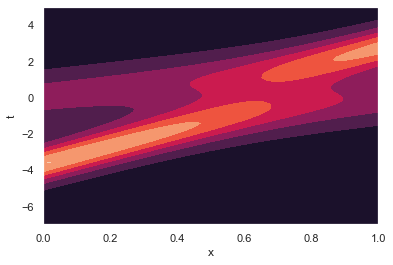

In [3]:
plt.contourf(t_grid, x_grid, y_full.reshape(x_grid.shape))
plt.xlabel('x')
plt.ylabel('t')

Now we sample on a square grid:

In [4]:
# Making training set
x_sample = np.linspace(-7, 5, 50)
t_sample = np.linspace(0.0, 1.0, 40)
x_grid_sample, t_grid_sample = np.meshgrid(x_sample, t_sample, indexing='ij')
X_train, y_train = dataset.create_dataset(x_grid_sample.reshape(-1, 1), t_grid_sample.reshape(-1, 1), n_samples=0, noise=0.1, normalize=True, random=True)

In [5]:
(0.1 * torch.std(y_train))**2

tensor(0.0041)

# Baseline NN

In [6]:
# Configuring model
network = NN(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=2, diff_order=3, norm_time=False) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=2000, periodicity=100) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

In [ ]:
train(model, X_train, y_train, optimizer, sparsity_scheduler, delta=0.01, log_dir='runs/NN_test/') # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       1925     19.25%             428s   -7.28e+00   4.16e-03   3.41e-05   1.90e+02 

In [15]:
model.estimator_coeffs()

[array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.71376047],
        [ 0.        ],
        [-2.1207873 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.99172753],
        [ 0.        ],
        [ 0.31504622]])]

In [16]:
model.constraint_coeffs(sparse=True, scaled=True)

[tensor([[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [-0.7182],
         [ 0.0000],
         [-2.2358],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 1.1037],
         [ 0.0000],
         [ 0.4441]], grad_fn=<MaskedScatterBackward>)]

# SIREN

In [34]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)  # Function approximator
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=225, periodicity=100) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.999, 0.999), lr=0.00025, amsgrad=True) # Defining optimizer

In [35]:
train(model, X_train, y_train, optimizer, sparsity_scheduler, log_dir='runs//', max_iterations=3000) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
        225      7.50%             165s   -5.88e+00   8.23e-03   3.41e-04   1.30e+00 [tensor([False,  True, False, False, False, False, False, False, False, False,
        False, False])]
        325     10.83%             159s   -8.07e+00   2.66e-03   2.99e-04   6.34e-01 [tensor([False,  True, False, False, False,  True, False,  True, False, False,
        False, False])]
        425     14.17%             154s   -8.63e+00   1.95e-03   3.35e-04   7.10e-01 [tensor([False,  True, False, False, False, False, False, False, False, False,
        False, False])]
        525     17.50%             148s   -9.30e+00   1.33e-03   3.59e-04   5.31e-01 [tensor([False,  True, False, False, False, False, False, False, False, False,
        False, False])]
Algorithm converged. Stopping training.


In [19]:
model.estimator_coeffs()

[array([[ 0.        ],
        [ 0.17168353],
        [ 0.        ],
        [-0.76225889],
        [ 0.        ],
        [-0.22567462],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]])]

In [20]:
model.constraint_coeffs(sparse=True, scaled=False)

[tensor([[ 0.0000e+00],
         [ 1.7143e-01],
         [ 0.0000e+00],
         [-4.5420e-06],
         [ 0.0000e+00],
         [-3.3190e-01],
         [ 0.0000e+00],
         [ 0.0000e+00],
         [ 0.0000e+00],
         [ 0.0000e+00],
         [ 0.0000e+00],
         [ 0.0000e+00]], grad_fn=<MaskedScatterBackward>)]

In [17]:
model.constraint_coeffs(scaled=True, sparse=True)

[tensor([[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [-0.8803],
         [ 0.0000],
         [-1.7092],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]], grad_fn=<MaskedScatterBackward>)]

In [18]:
model.sparsity_masks

[tensor([False, False, False,  True, False,  True, False, False, False, False,
         False, False])]

# Conclusion

We have a good set of parameters for which we now both work and when. let's now test the sensitivity of Siren w.r.t the first sparsity moment and check the MSE if we dont do sparsity.